In [1]:
import pandas as pd
import numpy as np


In [2]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
product = pd.read_csv("data/olist_products_dataset.csv")
sellers = pd.read_csv("data/olist_sellers_dataset.csv")


In [3]:
def read_data():
    customers = pd.read_csv("data/olist_customers_dataset.csv")
    geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
    order_items = pd.read_csv("data/olist_order_items_dataset.csv")
    orders = pd.read_csv("data/olist_orders_dataset.csv")
    product = pd.read_csv("data/olist_products_dataset.csv")
    sellers = pd.read_csv("data/olist_sellers_dataset.csv")   
    return orders, customers, geolocation, sellers, order_items, product

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}\n')
    return cat_cols, num_cols, cat_but_car

In [5]:
def orders_merge():

    orders, customers, geolocation, sellers, order_items, product = read_data()
    # Order Items
    order_items = pd.merge(order_items, product[
        ["product_id", "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]],
                           on="product_id")

    order_items = order_items.groupby(["order_id", "seller_id", "product_id"])[
        ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]].sum()
    order_items.reset_index(inplace=True)

    orders = pd.merge(orders, order_items[
        ["order_id", "product_id", "seller_id", "product_weight_g", "product_length_cm", "product_height_cm",
         "product_width_cm"]], on="order_id")

    # Customers
    orders = pd.merge(orders,
                          customers[["customer_id", "customer_city", "customer_state", "customer_zip_code_prefix"]],
                          on="customer_id")


    geolocation = geolocation.groupby("geolocation_zip_code_prefix").agg(
        {"geolocation_lat": "mean", "geolocation_lng": "mean"})
    geolocation.reset_index(inplace=True)

    orders = pd.merge(orders, geolocation, left_on="customer_zip_code_prefix",
                          right_on="geolocation_zip_code_prefix")
    orders.rename(
        columns={"geolocation_lat": "customer_geolocation_lat", "geolocation_lng": "customer_geolocation_lng"},
        inplace=True)

    orders = pd.merge(orders, sellers[["seller_id", "seller_city", "seller_state", "seller_zip_code_prefix"]],
                          on="seller_id")

    orders = pd.merge(orders, geolocation, left_on="seller_zip_code_prefix",
                          right_on="geolocation_zip_code_prefix")
    orders.rename(
        columns={"geolocation_lat": "seller_geolocation_lat", "geolocation_lng": "seller_geolocation_lng"},
        inplace=True)

    return orders

In [6]:
def only_one_product(data):
    print(f"Shape Before Single Product Filtering: {data.shape}")
    # Orders with only one product
    index = data["order_id"].value_counts()[data["order_id"].value_counts() == 1].index

    data = data[data.order_id.isin(index)]
    data.reset_index(drop=True, inplace=True)
    print(f"Shape After Single Product Filtering: {data.shape}\n")
    return data

In [7]:
def data_preprocessing():
    orders_ = orders_merge()
    orders_ = orders_[orders_["order_status"] == "delivered"]
    orders_.reset_index(drop=True, inplace=True)

    for col in orders_.columns[3:8]:
        orders_[col] = pd.to_datetime(orders_[col])

    orders_ = orders_.dropna()
    orders_.reset_index(drop=True, inplace=True)

    orders_ = only_one_product(orders_)

    return orders_

In [8]:
def f_engineering():

    data = data_preprocessing()

    # Volume of products
    data["hacim"] = data["product_length_cm"] * data["product_height_cm"] * data["product_width_cm"]

    data["purchase_month"] = data["order_purchase_timestamp"].apply(lambda x: x.month)


    # Time taken from order to reach the customer (in days)
    data["order_completion_day"] = [
        (pd.to_datetime(d.strftime("%Y-%m-%d")) - pd.to_datetime(t.strftime("%Y-%m-%d"))).days
        for d, t in zip(data["order_delivered_customer_date"], data["order_purchase_timestamp"])]

    # Euclidean distances between seller and customer
    data["euclidean_distance"] = (np.sqrt(((data["customer_geolocation_lat"] - data["seller_geolocation_lat"]) ** 2) +
                                          ((data["customer_geolocation_lng"] - data["seller_geolocation_lng"]) ** 2)))
    
    return data

In [9]:
data = f_engineering()
day=data["order_completion_day"]



Shape Before Single Product Filtering: (99679, 26)
Shape After Single Product Filtering: (92799, 26)



In [12]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


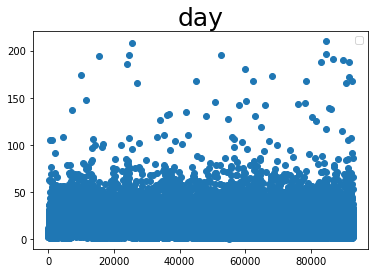

In [13]:
plt.figure(figsize=(6, 4))
plt.scatter(range(92799),day)
plt.title('day', fontsize=25)
plt.legend(loc='best')
plt.show()

In [14]:
data = f_engineering()

Shape Before Single Product Filtering: (99679, 26)
Shape After Single Product Filtering: (92799, 26)



In [35]:
data.loc[data["order_completion_day"] >= 30, "target"] = "30+"

data.loc[(3>= data["order_completion_day"]) & (data["order_completion_day"] >=1), "target"] = "1-3"

data.loc[(9>= data["order_completion_day"]) & (data["order_completion_day"] >=4), "target"] = "4-9"

data.loc[(15>= data["order_completion_day"]) & (data["order_completion_day"] >=10), "target"] = "10-15"

data.loc[(30>= data["order_completion_day"]) & (data["order_completion_day"] >=16), "target"] = "16-30"
day = data[["target"]]

In [36]:
day = day.groupby(["target"])["target"].count().reset_index(name='count')
input = list(day["count"])

In [37]:
input

[6635, 26884, 19511, 4189, 35579]

In [38]:
day1 = data[["order_completion_day"]]
day1 = data.groupby(["order_completion_day"])["order_completion_day"].count().reset_index(name='count')

In [39]:
input = list(day1["count"])

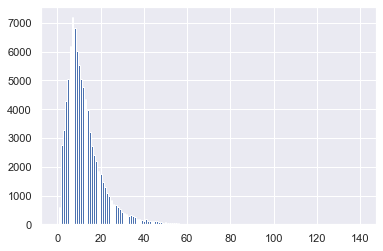

In [40]:

plt.bar(range(len(input)),input)

plt.show()

In [34]:
def target_variable_tags():

    data = f_engineering()
    data.loc[data["order_completion_day"] >= 30, "target"] = "30+"

    data.loc[(3>= data["order_completion_day"]) & (data["order_completion_day"] >=1), "target"] = "1-3"

    data.loc[(9>= data["order_completion_day"]) & (data["order_completion_day"] >=4), "target"] = "4-9"

    data.loc[(15>= data["order_completion_day"]) & (data["order_completion_day"] >=10), "target"] = "10-15"

    data.loc[(30>= data["order_completion_day"]) & (data["order_completion_day"] >=16), "target"] = "16-30"
    

    data["target"] = [str(i) for i in data["target"]]
    data = data[~(data["target"] == "nan")]
    data.reset_index(drop=True, inplace=True)

    return data

Modeling

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [22]:
def model():

    data = target_variable_tags()
    models = []
    models.append(('LightGBM', LGBMClassifier(random_state=55)))
    models.append(('RandomForest', RandomForestClassifier(random_state=55)))

    train, test = train_test_split(data, random_state=55, test_size=0.20)
    X_train = train[["product_weight_g", "hacim",  "purchase_month","euclidean_distance"]]
    y_train = train["target"]
    X_test = test[["product_weight_g", "hacim", "purchase_month","euclidean_distance"]]
    y_test = test["target"]

    
    print("\nBase Model Accuracy Scores")
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train_pred = model.predict(X_train)
        print(f"{name} train: {accuracy_score(y_train, train_pred)}")
        print(f"{name} test: {accuracy_score(y_test, y_pred)}")

    return LGBMClassifier(random_state=55).fit(X_train,y_train), X_train

In [23]:
def plot_importance(model, features, num, save=False):
    import seaborn as sns
    from matplotlib import pyplot as plt

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

final_model, X_train = model()


Shape Before Single Product Filtering: (99679, 26)
Shape After Single Product Filtering: (92799, 26)


Base Model Accuracy Scores
LightGBM train: 0.5164066919906247
LightGBM test: 0.47957974137931036
RandomForest train: 0.9995150731431343
RandomForest test: 0.4380387931034483


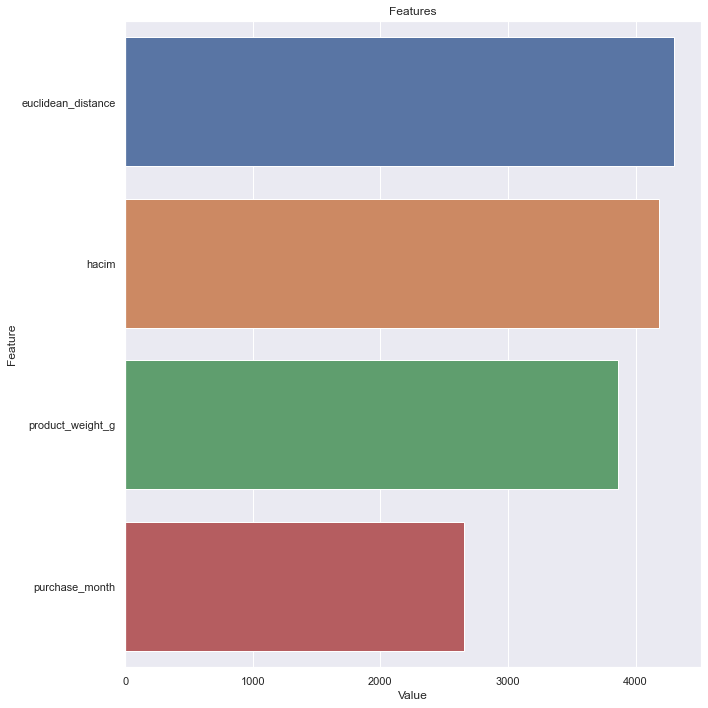

In [27]:
plot_importance(final_model, X_train, len(X_train))

In [41]:
train, test = train_test_split(data, random_state=55, test_size=0.20)
X_train = train[["product_weight_g", "hacim",  "purchase_month","euclidean_distance"]]
y_train = train["target"]
X_test = test[["product_weight_g", "hacim", "purchase_month","euclidean_distance"]]
y_test = test["target"]

In [60]:
X_train[3:4]

,product_weight_g,hacim,purchase_month,euclidean_distance
35491,500.0,19305.0,2,0.644786


In [51]:
y_train[3:4]

90812    4-9
Name: target, dtype: object

In [61]:
y_pred = final_model.predict(X_train[3:4])

In [62]:
y_pred

array(['4-9'], dtype=object)